# Population vector analysis 

'''Created on Thu 27 Aug 2020'''

In this notebook we will analyze the population vector for different behaviours of the mouse and different object explorations. 
The general analysis can be implemented in the differents types of preprocessing (day wise, with registration trial wise or day wise) but we will focus in different day analysis. 
In this experiement we have 4 traning days and one testing, so we will organize the data in order to use those multiple files

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
import scipy
cmap = cm.jet
import math

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 32365          ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                 ## value of resampling
session_now = 3
period = int(6 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
            if mouse == 32364:
                fixed = 'UL and UR'
            if mouse == 56165:
                fixed = 'UR and LR (verify)'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'UL'
            
if mouse == 32366:
    sessions = [3,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/population_analysis/'

In [4]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
day = 1
for trial in [1,6,11,16,21]:
    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                          '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = sstats.zscore(neural_activity1)
    
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                        re_sf=re_sf)
    
    activity_list.append(resample_neural_activity_mean)
    
    time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                          '.' + f'{0}' + '_10.pkl'
    timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
    timeline_info = pickle.load(timeline_file)
    ##normalize neural activity
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = activity.shape[1]
    resample_timeline = timeline_1/re_sf

    timeline_list.append(resample_timeline)
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' +'_day_'+f'{day}'+'_event_' + f'{re_sf}' + '.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    #c = np.linspace(0, 20, len(behaviour))
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
    resample_timeline = timeline_1/re_sf
    
    behaviour_list.append(resample_beh1)
    day = day + 1

In [5]:
# for each day creates a list that counts and saves times of different events.
# We will consider events here as resting period, navigation periods and object exploration periods.
# Later on will also consider different objects in the exploration periods

events_day_list = []
events_counter_day_list = []
events_time_starts_day = []
for day in range(len(behaviour_list)):
    events_list = []
    events_counter_list = []
    events_time_starts = []
    start_counter = 100
    counter = 0
    for i in range(behaviour_list[day].shape[0]):
        if behaviour_list[day][i] != start_counter:
            events_list.append(start_counter)
            events_counter_list.append(counter)
            events_time_starts.append(i)
            start_counter = behaviour_list[day][i]
            counter = 1
        else:
            counter = counter + 1
    events_day_list.append(events_list)
    events_counter_day_list.append(events_counter_list)
    events_time_starts_day.append(events_time_starts)

In [6]:
# separte events belonging to each of the behavioural conditions

behavioural_events_days_list = []
conditions = [ 'Resting', 'Navigation', 'Object_exploration']

for day in range(len(behaviour_list)):
    events = np.array(events_day_list[day])
    events[np.where(events>1)] = 2
    events_counter = np.array(events_counter_day_list[day])
    events_time = np.array(events_time_starts_day[day])

    object_list = []
    for target in [0,1,2]:
        period1 = period
        if target == 0:
            period1 = period_resting
        object_data = []
        position_events = np.where(events == target)[0]
        events_duration = events_counter[position_events]   # convert to seconds
        time = events_time[position_events]
        i = 0
        for event in events_duration:
            if event > period:
                object_data.append(activity_list[day][:,time[i]:time[i]+period1])
            i = i + 1
        object_list.append(object_data)
    behavioural_events_days_list.append(object_list)

Up to here, we created a list (behavioural_events_days_list) that has 5 elements corresponding to each day
Each element of the list, is itself a list, containing three new elements that are related to different behaviours
and each list for each behavior is a list of activity (calcium trace) matrix of size number of neurons X period.
where period is a variable we can choose.

As number of neurons is different for each day, we will compare behavioural conditions within a day. 

Lets now compute the population vector for the three behavioural conditions, and plot it for different days.
Population vector here will be the mean over the period of time choosen

In [7]:
population_vector = []
for day in range(len(behaviour_list)):
    mean_over_trials_list = []
    for i in range(len(behavioural_events_days_list[day])):
        mean_over_trials= np.mean(behavioural_events_days_list[day][i], axis= 0)
        if mean_over_trials.shape:
            mean_over_trials_list.append(np.mean(mean_over_trials,axis=1))#/np.max(np.mean(mean_over_trials,axis=1)))
    population_vector.append(mean_over_trials_list)

/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[9.01477787824687e-18, 8.057042198963623e-18, 6.943331510851931e-18, 7.39748931534514e-18, 8.833041406132479e-17]


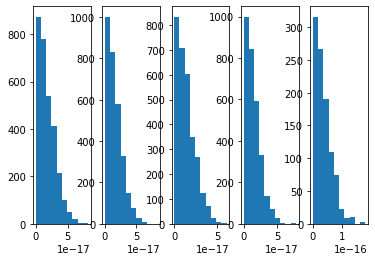

In [8]:
## compute null hypotesis for euclidean distance

# we compute for each day a matrix containing all the activity
matrix = []
matrix_elements_size= []
for day in range(len(behavioural_events_days_list)):
    matrix_list = []
    matrix_size = 0
    matrix_limits = []
    for i in range(len(behavioural_events_days_list[day])):
        if behavioural_events_days_list[day][i]:
            period1 = period
            if i == 0:
                period1 = period_resting
            mean_over_trials =  np.mean(behavioural_events_days_list[day][i], axis= 0)            
            matrix1 = np.zeros((len(mean_over_trials),period1*len(behavioural_events_days_list[day][i])))
            for j in range(len(behavioural_events_days_list[day][i])):
                matrix1[:,j*period1:(j+1)*period1] = behavioural_events_days_list[day][i][j]
            matrix_list.append(matrix1)
            matrix_limits.append([matrix_size, matrix_size + period1*len(behavioural_events_days_list[day][i])])
            matrix_size = matrix_size + period1*len(behavioural_events_days_list[day][i])
    auxiliar_matrix = np.zeros((len(mean_over_trials),matrix_size))
    for i in range(len(matrix_list)):
        auxiliar_matrix[:,matrix_limits[i][0]:matrix_limits[i][1]] = matrix_list[i]
    matrix.append(auxiliar_matrix)
    matrix_elements_size.append(matrix_limits)


## compute null distribution of distances over randomly selected group of bins
n_shufflings = 1000
null_distribution_list = []
for day in range(len(behavioural_events_days_list)):
    data = matrix[day]
    null_distribution = []
    for i in range(n_shufflings):
        random_order = np.random.randint(0,data.shape[1],data.shape[1])
        mean_list = []
        for j in range(len(matrix_elements_size[day])):
            random_values = random_order[matrix_elements_size[day][j][0]:matrix_elements_size[day][j][1]]
            mean_vector = np.mean(matrix[day][:,random_values])
            mean_list.append(mean_vector)
        for j in range(len(mean_list)):
            for k in range(j+1,len(mean_list)):
                distance = np.linalg.norm(mean_list[j]-mean_list[k])
                null_distribution.append(distance)
    null_distribution_list.append(null_distribution)         
    
## plot null distribution for different days

fig = plt.figure()
gs = plt.GridSpec(1,5)
for day in range(len(null_distribution_list)):
    ax = fig.add_subplot(gs[0, day])
    ax.hist(null_distribution_list[day])
    
## sort null distribution values and take 95%
null_distribution_limit = []
for day in range(len(null_distribution_list)):
    sorted_null_distribution = np.sort(null_distribution_list[day])
    null_distribution_limit.append(sorted_null_distribution[950])   
print(null_distribution_limit)
    
## compute euclidean distance matrix using normalization
euclidean_distance_list = []
for day in range(len(behaviour_list)-1):
    euclidean_distance = np.zeros((len(population_vector[day]),len(population_vector[day])))
    for i in range(len(population_vector[day])):
        for j in range(len(population_vector[day])):
            distance = np.linalg.norm(population_vector[day][i]-population_vector[day][j])
            euclidean_distance[i,j]= distance / population_vector[day][i].shape
    euclidean_distance_list.append(euclidean_distance)


/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


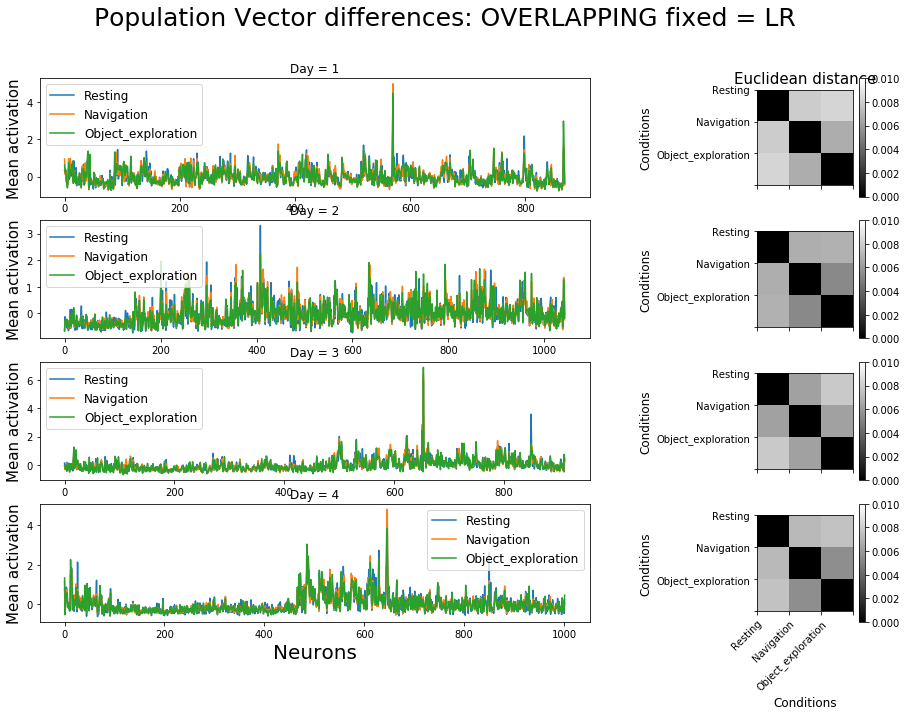

In [12]:
fig = plt.figure()
gs = plt.GridSpec(len(behaviour_list)-1, 6)

vmin= 0
vmax=0.01

for day in range(len(behaviour_list)-1):
    ax = fig.add_subplot(gs[day, 0:4])
    
    ax.plot(population_vector[day][0])
    ax.plot(population_vector[day][1])
    ax.plot(population_vector[day][2])
    
    ax.legend(conditions, fontsize = 12)
    if day == len(behaviour_list)-2:
        ax.set_xlabel('Neurons', fontsize = 20)
    ax.set_ylabel('Mean activation', fontsize = 15)
    ax.set_title('Day = ' + f'{day+1}')
    
    
    ax1 = fig.add_subplot(gs[day, 5])
    if day == 0:
        ax1.set_title('Euclidean distance', fontsize = 15)
    x = ax1.imshow(euclidean_distance_list[day], cmap = 'gray')
    #x = ax.pcolormesh(euclidean_distance_list[day], cmap = 'gray')
    x.set_clim(vmin,vmax)
    
    x_pos = np.arange(-0.5,len(conditions)+0.5)
    ax1.set_yticks(x_pos)
    ax1.set_yticklabels(conditions)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([])
    if day == len(behaviour_list)-2:
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(conditions)
        ax1.set_xlabel('Conditions', fontsize = 12)
    ax1.set_ylabel('Conditions', fontsize = 12)
    
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fig.colorbar(x, ax=ax1)

    
fig.tight_layout()
fig.set_size_inches(15,10)
fig.suptitle('Population Vector differences: ' + task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'population_vector_events_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

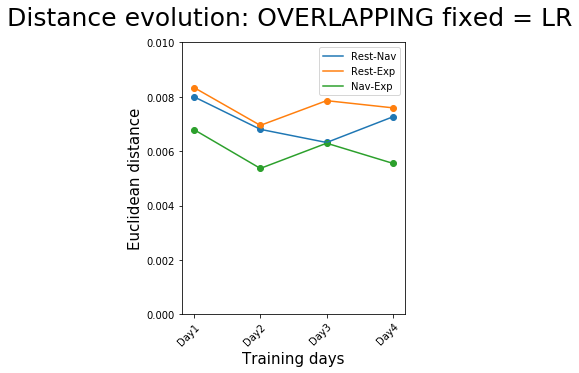

In [11]:
## plot evolution of euclidean distance in multiple days

evolution = np.zeros((4,3))
for day in range(len(euclidean_distance_list)):
    evolution[day][0] = euclidean_distance_list[day][0,1]
    evolution[day][1] = euclidean_distance_list[day][0,2]
    evolution[day][2] = euclidean_distance_list[day][1,2]

condition = ['Rest-Nav','Rest-Exp','Nav-Exp']
x_axes = ['Day1', 'Day2', 'Day3', 'Day4']
fig, axes = plt.subplots(1)
for i in range(3):
    axes.scatter([1,2,3,4],evolution[:,i])
    axes.plot([1,2,3,4],evolution[:,i])
axes.legend(condition)
axes.set_xlabel('Training days', fontsize = 15)
axes.set_ylabel('Euclidean distance', fontsize = 15)
x_pos = np.arange(1,5)
axes.set_ylim([0, 0.01])
axes.set_xticks(x_pos)
axes.set_xticklabels(x_axes)
plt.setp(axes.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


#fig.tight_layout()
fig.set_size_inches(4,5)
fig.suptitle('Distance evolution: ' + task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'distance_evolution_events_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)